![alt text](https://greenheritagellc.github.io/portal/images//Green%20Heritage%20Logo.png "Logo Title Text 1")

# Books Recommendation Engine

* This notebook recommends a set of books similar to other books based on crowdsourced book rating by users
* It uses item based collberative filtering to achieve this
* Citation: Books dataset has been downloaded from http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import int64

import requests
import IPython.display as Disp

import sklearn
from sklearn.decomposition import TruncatedSVD


### download books and ratings info

In [3]:
 books_df = pd.read_csv("./dataset/books.csv")
 ratings_df = pd.read_csv("./dataset/ratings.csv", encoding='UTF-8',  dtype={'user_id': int,'book_id':int, 'rating':int} )

In [4]:
books_df.head()
#ratings_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [26]:
books_df.describe()
books_df_2 = books_df[['book_id', 'books_count', 'original_publication_year', 'average_rating','original_title','image_url','authors']]

books_df_2.head()

len(books_df)

10000

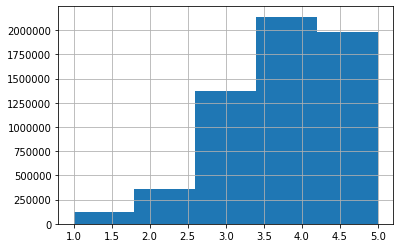

In [7]:
ratings_df.rating.hist(bins=5)

In [8]:
ratings_df.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


In [27]:
ratings_df.groupby('user_id')['rating'].count()

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Name: rating, Length: 53424, dtype: int64

## Merge books and ratings dataset

In [9]:
combined_books_df = pd.merge(ratings_df, books_df, on='book_id')

In [10]:
combined_books_df.head()

,user_id,book_id,rating,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
1,11,258,3,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
2,143,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
3,242,258,5,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...
4,325,258,4,1232,1232,3209783,279,143034901,9.780143e+12,"Carlos Ruiz Zafón, Lucia Graves",...,263685,317554,24652,4789,11769,42214,101612,157170,https://images.gr-assets.com/books/1344545047m...,https://images.gr-assets.com/books/1344545047s...


### Get most rated books

In [11]:
combined_books_df.groupby('book_id')['rating'].count().sort_values(ascending=False)

book_id
1       22806
2       21850
4       19088
3       16931
5       16604
        ...  
9315       36
1935       33
9486       24
9345       11
7803        8
Name: rating, Length: 10000, dtype: int64

In [56]:
Filter = combined_books_df['book_id'] < 10
combined_books_df[Filter]['original_title'].unique()
#printBookCover(Filter)

array(["Harry Potter and the Philosopher's Stone", 'The Great Gatsby',
       'The Catcher in the Rye', 'Angels & Demons ',
       'To Kill a Mockingbird', 'The Hobbit or There and Back Again',
       'Twilight', 'The Hunger Games', 'The Fault in Our Stars'],
      dtype=object)

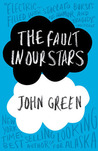

In [80]:
url =combined_books_df[Filter]['image_url'].unique()[8]
Disp.Image(requests.get(url).content)

### Create Pivot Table of User Vs Movies

In [30]:
ct_df = combined_books_df.pivot_table(values='rating', index='user_id', columns='original_title', fill_value=0)

In [31]:
ct_df.head()

original_title,,A Monster Calls,Animal Farm & 1984,"Burned (Burned, #1)",Call the midwife : a true story of the East End in the 1950s,"Carry On, Warrior: Thoughts on Life Unarmed",Carter Beats the Devil,Crown of Shadows,Daemon,De Imitatione Christi,...,電撃デイジー 1,青の祓魔師 1,青の祓魔師 2,高校デビュー 1,黑暗森林,黒執事 I [Kuroshitsuji I],黒執事 II [Kuroshitsuji II],黒執事 III [Kuroshitsuji III],엄마를 부탁해,채식주의자
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
X = ct_df.values.T
X.shape

(9274, 53424)

### Compress dataset by applying Singular Value Decomposistion (SVD)

In [34]:
SVD  = TruncatedSVD(n_components=20, random_state=17)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(9274, 20)

### Create Pearson coorelation matrix

In [35]:
corr_mat = np.corrcoef(result_matrix)
corr_mat.shape

(9274, 9274)

### Print books related to specified book


In [71]:
book_names = ct_df.columns
book_list = list(book_names)
hunger_game_index = book_list.index('The Hunger Games')


In [72]:
corr_hunger_games = corr_mat[hunger_game_index]
corr_hunger_games.shape

(9274,)

In [73]:
list(book_names[(corr_hunger_games<1.0) & (corr_hunger_games>0.8)])

['Catching Fire',
 'Mockingjay',
 'Pride and Prejudice and Zombies',
 'The Host',
 'The Hunger Games Box Set',
 'Twilight']